<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [3]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.6 MB/s eta 0:00:00


### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [4]:
import pyupbit

# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-06 09:00:00,60230000.0,61312000.0,59572000.0,60314000.0,8840.709910,5.336398e+11
2023-12-07 09:00:00,60295000.0,60958000.0,58555000.0,59250000.0,8318.924757,4.969294e+11
2023-12-08 09:00:00,59237000.0,60753000.0,58750000.0,60142000.0,5252.133202,3.128890e+11
2023-12-09 09:00:00,60148000.0,60395000.0,59680000.0,60082000.0,3528.907593,2.121763e+11


In [5]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2268 entries, 2017-09-25 09:00:00 to 2023-12-10 09:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2268 non-null   float64
 1   high    2268 non-null   float64
 2   low     2268 non-null   float64
 3   close   2268 non-null   float64
 4   volume  2268 non-null   float64
 5   value   2268 non-null   float64
dtypes: float64(6)
memory usage: 124.0 KB


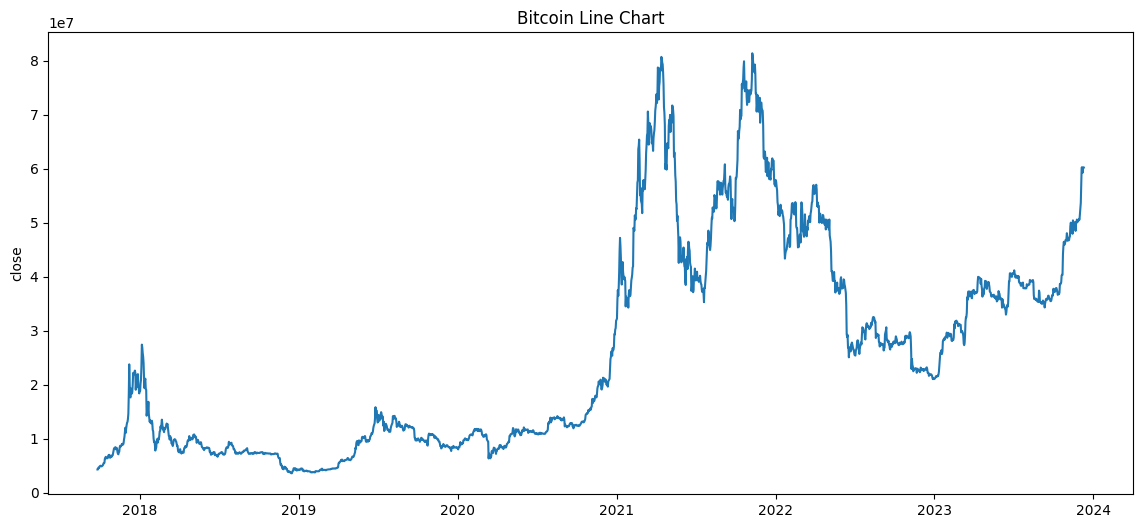

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart');

## LSTM(Long Short Term Memory)
---
본 프로젝트에서는 long memory 특성을 보이는 비트코인의 가격 예측을 위한 딥러닝 모형으로 LSTM을 선택하였습니다. LSTM 모형을 이용하여 비트코인의 가격을 예측하고, 예측된 비트코인 가격을 이용한 이동평균선 교차 전략의 투자 성과를 비교 분석하겠습니다.

> [LSTM(Long Short-Term Memory)](https://wikidocs.net/152773) 모델은 순환 신경망(Recurrent Neural Network, RNN)의 한 종류로서, 시퀀스 데이터를 처리하는 데 효과적입니다. LSTM은 RNN의 장기 의존성 문제를 해결하기 위해 고안되었습니다.

### 1. 데이터 전처리
일별 수익률(`Return`) 컬럼을 추가합니다.

In [16]:
# 원본 복사
df = df_origin.copy()

df['Return'] = df['close'].pct_change()
df.head()

,open,high,low,close,volume,value,Return
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,NaN
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,-0.000231
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,0.077760
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,-0.015246
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,0.015482


`MinMaxScaler()` 최소/최대값이 각각 0, 1이 되도록 하여스 모든 feature 값이 0~1 사이에 있도록 데이터를 재조정합니다.

이 기능은 각 feature들에서 최소값(minimum)을 빼고, 전체 범위로 나눈다. 범위는 데이터의 최대값에서 데이터의 최소값을 뺀 값이 된다.

\Y =

MinMaxScaler의 표준화 방식
이 방법은 본래 데이터의 분포를 유지한다는 특징이 있다. 즉, 본래 데이터의 정보를 변형시키지 않는다는 장점이 있다. 그러나, 이 방법은 이상치(outliers)의 영향을 줄이지는 못한다. 계산된 값들은 0과 1사이의 범위로 축소된다. 만약, 본래 데이터의 정규분포를 변형시키고 싶지 않거나, 이상치의 영향을 그대로 보고 싶은 경우, 표준화를 위해 가장 먼저 시도해 볼 수 있는 방법이다. 성공적으로 적용이 되었다면, 아래와 같은 kdeplot을 볼 수 있다. 원래 데이터의 kdeplot과 비교해 보더라도, 각 feature들 사이의 상대적인 거리가 유지된 것을 알 수 있다. Scaling의 기법이라 할 수 있다.



In [18]:
from sklearn.preprocessing import MinMaxScaler

# 입력 변수 설정
input_data = df[['open', 'high', 'low', 'close', 'Return']].values

scaler = MinMaxScaler()

input_data

array([[ 4.20100000e+06,  4.33300000e+06,  4.17500000e+06,
         4.32200000e+06,             nan],
       [ 4.31700000e+06,  4.41800000e+06,  4.31100000e+06,
         4.32100000e+06, -2.31374364e-04],
       [ 4.32200000e+06,  4.67700000e+06,  4.31800000e+06,
         4.65700000e+06,  7.77597778e-02],
       ...,
       [ 5.92370000e+07,  6.07530000e+07,  5.87500000e+07,
         6.01420000e+07,  1.50548523e-02],
       [ 6.01480000e+07,  6.03950000e+07,  5.96800000e+07,
         6.00820000e+07, -9.97638921e-04],
       [ 6.00820000e+07,  6.02700000e+07,  6.00540000e+07,
         6.02490000e+07,  2.77953464e-03]])

In [8]:
import numpy as np


df['candle'] = ((df['close'] - df['open']) / df['open'] * 100).round(1)  # 가격 변화율 열 추가
df['volume_change_rate'] = (df['volume'].pct_change() * 100).round(1)  # 거래량 변화율 열 추가
df['profit_loss'] = np.where(df['close'].shift(-1) > df['open'].shift(-1), 1, 0)  # profit_loss 열 추가

# 첫 행과 마지막 행 삭제
df.drop([df.index[0], df.index[-1]], inplace=True)
# 불필요한 컬럼 삭제
df.drop(["open", "high", "low", "close", "volume", "value"], axis=1, inplace=True)

print(df.shape)
df.head()


(2266, 3)


,candle,volume_change_rate,profit_loss
2017-09-26 09:00:00,0.1,-82.8,1
2017-09-27 09:00:00,7.8,41.6,0
2017-09-28 09:00:00,-1.5,149.7,1
2017-09-29 09:00:00,1.5,-26.4,1
2017-09-30 09:00:00,5.1,-66.3,1


분류 문제는 항상 먼저 타겟의 범주가 어떤 비율을 가지고 있는지 확인해 보아야 합니다.

타겟 범주의 분포가 균형을 이루지 않고 한쪽으로 치우친 경우, 머신러닝 모델은 다수의 범주에 치우쳐 학습할 가능성이 높습니다. 이러한 상황에서는 소수의 범주에 대한 예측 성능이 저하될 수 있습니다.

타겟 데이터의 비율:
 1    0.518094
0    0.481906
Name: profit_loss, dtype: float64


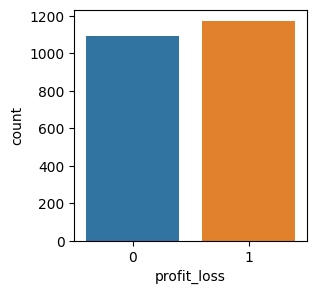

In [9]:
# 타겟 데이터 범주의 비율을 확인합니다.
y =  df['profit_loss']
print("타겟 데이터의 비율:\n", y.value_counts(normalize=True))

plt.figure(figsize=(3, 3))
sns.countplot(x=y);

### 1-2. Modeling
[교차 검증(Cross-Validation)](https://sodayeong.tistory.com/224)은 모델의 성능을 평가하고 일반화 능력을 확인하는 데 사용되는 통계적 방법입니다. 이 방법을 사용하면 과적합(Overfitting)을 피하고 모델의 예측 성능을 향상시킬 수 있습니다. 데이터를 여러 개의 하위 집합(subset)으로 나눈 다음, 일부 하위 집합을 훈련 데이터로, 나머지 하위 집합을 테스트 데이터로 사용하여 모델을 여러 번 학습하고 평가하게 됩니다.



In [10]:
from sklearn.model_selection import TimeSeriesSplit

# Features and target
X = df.drop('profit_loss', axis=1)
y = df['profit_loss']

# Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

> **기준 모델(Baseline Model)**은 예측 문제를 해결하기 위해 설정하는 단순한 모델이나 기준을 의미합니다. 이 모델은 일반적으로 복잡한 머신러닝 모델을 사용하기 전에, 문제를 얼마나 잘 이해하고 있는지, 어떤 방식으로 접근해야하는지를 판단하는 데 도움을 줍니다.

본 프로젝트에서는 타겟 변수의 **최빈값**으로 기준모델을 설정합니다.



In [11]:
from sklearn.metrics import classification_report

for train_index, test_index in tscv.split(y):
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  base = y_train.mode()[0]  # 최빈값
  base_pred = [base] * len(y_test)

  # 성능 평가
  print('Base Model Report:')
  print(classification_report(y_test, base_pred))
  print('-'*53)

Base Model Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.53      1.00      0.69       199

    accuracy                           0.53       377
   macro avg       0.26      0.50      0.35       377
weighted avg       0.28      0.53      0.36       377

-----------------------------------------------------
Base Model Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       173
           1       0.54      1.00      0.70       204

    accuracy                           0.54       377
   macro avg       0.27      0.50      0.35       377
weighted avg       0.29      0.54      0.38       377

-----------------------------------------------------
Base Model Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.53      1.00      0.70       201

    accuracy     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

for train_index, test_index in tscv.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # 성능 평가
  print('Logistic Regression Report:')
  print(classification_report(y_test, y_pred))
  print('-'*53)

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.38      0.08      0.13       178
           1       0.52      0.88      0.65       199

    accuracy                           0.50       377
   macro avg       0.45      0.48      0.39       377
weighted avg       0.45      0.50      0.41       377

-----------------------------------------------------
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       173
           1       0.54      1.00      0.70       204

    accuracy                           0.54       377
   macro avg       0.27      0.50      0.35       377
weighted avg       0.29      0.54      0.38       377

-----------------------------------------------------
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.48      0.06      0.10       176
           1       0.53      0.95      0.68  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

### 데이터 정규화 및 기준모델의 정확도 계산

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Scaling
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
y_pred_base = len(y_test) * [base]
# 기준모델의 정확도
print("Train accuracy:", accuracy_score(y_train, baseline).round(3))
print("Test accuracy:", accuracy_score(y_test, y_pred_base).round(3))

Train accuracy: 0.522
Test accuracy: 0.499


### 기준모델의 Confusion Matrix

In [14]:
y_true0 = y_test.value_counts()[0]
y_true1 = y_test.value_counts()[1]
confusion_base = pd.DataFrame(index = ['True 0', 'True 1'], data = {'Predicted 0':[0,0], 'Predicted 1':[y_true0,y_true1]})
confusion_base

NameError: ignored

### 모델의 정확도

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀
logCV_model = LogisticRegressionCV(cv=5)
logCV_model.fit(X_train_std, y_train)

# 로지스틱 회귀모델의 정확도
print("Train accuracy:", logCV_model.score(X_train_std, y_train).round(3))

### 평가지표

In [ ]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))